In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hiv-prevalence/updated 2.csv


To analyze the impact of PrEP approval on HIV prevalence, we will conduct a Difference-in-Differences (DiD) analysis.

1. Research Question
Did the introduction of PrEP lead to a significant reduction in HIV prevalence in developed countries?

Methodology

A. Define the Treatment and Control Groups

Treatment Group: Countries that approved PrEP in a given year.

Control Group: Countries that had not yet approved PrEP by that year.


Treatment Group: Canada, Australia, France, Germany, Norway, Switzerland, Denmark, UK.

Control Group: Countries that approved PrEP after 2016 (e.g., Belgium, Ireland, Italy, Spain, Poland).

B. Difference-in-Differences (DiD) Approach

Baseline Period: 5 years before PrEP approval.

Post-Treatment Period: 5 years after PrEP approval.

Assumption: Without PrEP, the treatment and control groups would have had similar trends in HIV prevalence.

3. Data Preparation
4. 
Convert the dataset into a panel format: Country | Year | HIV Prevalence | PrEP Approval Year.

Add a "Post-PrEP" column:

1 if year is after PrEP approval.

0 if year is before PrEP approval.

Label countries as treatment or control based on approval year.

6. Visualization
   
Trend Line Graphs:

Plot HIV prevalence before and after PrEP introduction.

Compare treatment and control countries.

DiD Visualization:

Show the difference in HIV prevalence trends pre- and post-PrEP.

8. Hypothesis Testing
Null Hypothesis (
​
 ): PrEP has no effect on HIV prevalence.
Alternative Hypothesis (
𝐻
𝐴
H 
A
​
 ): PrEP reduces HIV prevalence.

Run linear regression with fixed effects to control for country-specific factors.

10. Expected Findings
    
If PrEP was effective, we should see a greater decline in HIV prevalence in treatment countries compared to control countries.

If no significant effect is found, other factors (e.g., testing expansion, ART improvements) might be driving HIV prevalence trends.



In [2]:
import pandas as pd
HIV = pd.read_csv("/kaggle/input/hiv-prevalence/updated 2.csv")

In [3]:
HIV.head()

,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2007 [YR2007],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Canada,CAN,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,0.08,0.08,0.08,0.08,0.08,0.08,...,0.07,0.05,0.05,0.05,0.05,0.05,0.04,..,..,..
1,Canada,CAN,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,0.14,0.14,0.14,0.14,0.13,0.13,...,0.13,0.1,0.1,0.1,0.1,0.1,0.08,..,..,..
2,Canada,CAN,"Incidence of HIV, ages 15-24 (per 1,000 uninfe...",SH.HIV.INCD.YG.P3,0.06,0.06,0.06,0.06,0.05,0.05,...,0.05,0.04,0.04,0.04,0.04,0.04,0.03,..,..,..
3,United States,USA,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,United States,USA,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,..,..,..,..,..,..,...,..,0.21,0.21,0.2,0.2,0.19,0.18,0.17,..,..


Reshape the Data from Wide to Long Format

We’ll first load the dataset, then reshape it into long format.

In [6]:
import pandas as pd

# Load your data (replace with the actual path)
HIV = pd.read_csv('/kaggle/input/hiv-prevalence/updated 2.csv')

# Reshape from wide to long format
data_long = pd.melt(HIV, 
                    id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'], 
                    var_name='Year', 
                    value_name='HIV_Incidence')

# Convert 'Year' to integer for comparison
data_long['Year'] = data_long['Year'].str.extract('(\d+)').astype(int)

# View the reshaped data
data_long.head()


,Country Name,Country Code,Series Name,Series Code,Year,HIV_Incidence
0,Canada,CAN,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,0.08
1,Canada,CAN,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,0.14
2,Canada,CAN,"Incidence of HIV, ages 15-24 (per 1,000 uninfe...",SH.HIV.INCD.YG.P3,2000,0.06
3,United States,USA,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,..
4,United States,USA,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,..


Merge PrEP Approval Years

Next, create a PrEP approval year dataset.

Country	PrEP   Approval Year	
United States  2012	
Canada	       2016	
Australia	   2016	
France	       2015	
Germany	       2016	
Norway	       2016	
United Kingdom 2016	
Belgium	       2017	
Ireland	       2017	
Italy	       2017	
Netherlands	   2017	
New Zealand	   2018	
Sweden	       2017	
Switzerland	   2016	
Denmark    	   2016	
Greece	       2017	
Luxembourg	   2017	
Portugal	   2017	
Austria	       2017	
Spain	       2019	
Poland	       2019	
Japan	   Not Approved	

In [7]:
# Sample PrEP approval data (replace this with actual data for each country)
prep_data = {
    'Country Name': ['Canada', 'United States', 'Australia', 'Germany', 'United Kingdom','France','Norway','Belgium','Ireland','Italy','Netherlands','Newzealand','Sweden','Switzerland','Denmark','Greece','Luxembourg','Portugal','Austria','Spain','Poland','Japan'],
    'PrEP_Approval_Year': [2016, 2012, 2016, 2016, 2016,2015,2016,2017,2017,2017,2017,2018,2017,2016,2016,2017,2017,2017,2017,2019,2019,None]  # Example approval years
}

prep_df = pd.DataFrame(prep_data)

# Merge the PrEP approval year with the long-format HIV data
data_long = pd.merge(data_long, prep_df, on='Country Name', how='left')

# View the data with merged PrEP approval year
data_long.head()


,Country Name,Country Code,Series Name,Series Code,Year,HIV_Incidence,PrEP_Approval_Year
0,Canada,CAN,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,0.08,2016.0
1,Canada,CAN,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,0.14,2016.0
2,Canada,CAN,"Incidence of HIV, ages 15-24 (per 1,000 uninfe...",SH.HIV.INCD.YG.P3,2000,0.06,2016.0
3,United States,USA,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,..,2012.0
4,United States,USA,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,..,2012.0


In [8]:
# Convert 'PrEP_Approval_Year' to integer while handling NaNs correctly
data_long['PrEP_Approval_Year'] = pd.to_numeric(data_long['PrEP_Approval_Year'], errors='coerce')

# Now convert the column to nullable Int64 type, which can handle NaN correctly
data_long['PrEP_Approval_Year'] = data_long['PrEP_Approval_Year'].astype('Int64')

# Check the result
data_long.head()


,Country Name,Country Code,Series Name,Series Code,Year,HIV_Incidence,PrEP_Approval_Year
0,Canada,CAN,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,0.08,2016
1,Canada,CAN,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,0.14,2016
2,Canada,CAN,"Incidence of HIV, ages 15-24 (per 1,000 uninfe...",SH.HIV.INCD.YG.P3,2000,0.06,2016
3,United States,USA,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,..,2012
4,United States,USA,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,..,2012


Create Treatment Indicators

Now, we need to create two indicators:

Post_PrEP: 1 if year > PrEP approval year, 0 otherwise.

Treatment: 1 if the country has PrEP approval, 0 otherwise.

DiD_Term: Interaction of Post_PrEP and Treatment.



In [9]:
# Create the Post_PrEP indicator (1 if year > PrEP approval year, else 0)
data_long['Post_PrEP'] = (data_long['Year'] > data_long['PrEP_Approval_Year']).astype('Int64')

# Create the Treatment indicator (1 if country has PrEP, 0 otherwise)
data_long['Treatment'] = data_long['PrEP_Approval_Year'].notna().astype('Int64')

# Create the DiD Term (interaction of Post_PrEP and Treatment)
data_long['DiD_Term'] = data_long['Post_PrEP'] * data_long['Treatment']

# Check the dataset with the newly created indicators
data_long.head()


,Country Name,Country Code,Series Name,Series Code,Year,HIV_Incidence,PrEP_Approval_Year,Post_PrEP,Treatment,DiD_Term
0,Canada,CAN,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,0.08,2016,0,1,0
1,Canada,CAN,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,0.14,2016,0,1,0
2,Canada,CAN,"Incidence of HIV, ages 15-24 (per 1,000 uninfe...",SH.HIV.INCD.YG.P3,2000,0.06,2016,0,1,0
3,United States,USA,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,..,2012,0,1,0
4,United States,USA,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,..,2012,0,1,0


Run Difference-in-Differences (DiD) Regression

We will run the DiD regression for each age group separately (All Ages, Ages 15-49, and Ages 15-24

In [10]:
# Check for missing values in relevant columns
missing_data = data_long[['HIV_Incidence', 'Post_PrEP', 'Treatment', 'DiD_Term', 'Country Name', 'Year']].isnull().sum()
print("Missing values in each column:\n", missing_data)


Missing values in each column:
 HIV_Incidence    121
Post_PrEP        255
Treatment          0
DiD_Term         255
Country Name      51
Year               0
dtype: int64


Fill missing values with the mean (or median)

In [11]:
#Round the mean to an integer before filling
# Fill missing values with rounded mean (for integer columns)
data_long['Post_PrEP'] = data_long['Post_PrEP'].fillna(round(data_long['Post_PrEP'].mean()))
data_long['DiD_Term'] = data_long['DiD_Term'].fillna(round(data_long['DiD_Term'].mean()))

# Check if missing data has been handled
missing_data_cleaned = data_long[['HIV_Incidence', 'Post_PrEP', 'Treatment', 'DiD_Term', 'Country Name', 'Year']].isnull().sum()
print("Missing values after filling:\n", missing_data_cleaned)


Missing values after filling:
 HIV_Incidence    121
Post_PrEP          0
Treatment          0
DiD_Term           0
Country Name      51
Year               0
dtype: int64


In [12]:
data_long.head()

,Country Name,Country Code,Series Name,Series Code,Year,HIV_Incidence,PrEP_Approval_Year,Post_PrEP,Treatment,DiD_Term
0,Canada,CAN,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,0.08,2016,0,1,0
1,Canada,CAN,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,0.14,2016,0,1,0
2,Canada,CAN,"Incidence of HIV, ages 15-24 (per 1,000 uninfe...",SH.HIV.INCD.YG.P3,2000,0.06,2016,0,1,0
3,United States,USA,"Incidence of HIV, all (per 1,000 uninfected po...",SH.HIV.INCD.TL.P3,2000,..,2012,0,1,0
4,United States,USA,"Incidence of HIV, ages 15-49 (per 1,000 uninfe...",SH.HIV.INCD.ZS,2000,..,2012,0,1,0


In [13]:
import statsmodels.formula.api as smf
import pandas as pd

# Rename columns to avoid spaces
data_long = data_long.rename(columns={'Country Name': 'Country_Name'})

# Filter data for the three series (age groups)
age_groups = [
    'Incidence of HIV, all (per 1,000 uninfected population)', 
    'Incidence of HIV, ages 15-49 (per 1,000 uninfected population ages 15-49)', 
    'Incidence of HIV, ages 15-24 (per 1,000 uninfected population ages 15-24)'
]

# Initialize dictionary to store results
results = {}

for group in age_groups:
    # Filter the data for the current age group
    group_data = data_long[data_long['Series Name'] == group]
    
    # Ensure the 'HIV_Incidence' column is not a string (convert if necessary)
    group_data['HIV_Incidence'] = pd.to_numeric(group_data['HIV_Incidence'], errors='coerce')

    # DiD regression model
    model = smf.ols('HIV_Incidence ~ Post_PrEP + Treatment + DiD_Term + C(Country_Name) + C(Year)', 
                    data=group_data).fit()

    # Store the results
    results[group] = model.summary()

# View the DiD regression results
for group, result in results.items():
    print(f"Results for {group}:\n")
    print(result)
    print("\n" + "="*50 + "\n")


Results for Incidence of HIV, all (per 1,000 uninfected population):

                            OLS Regression Results                            
Dep. Variable:          HIV_Incidence   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     28.34
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           3.04e-49
Time:                        01:16:50   Log-Likelihood:                 531.83
No. Observations:                 194   AIC:                            -1006.
Df Residuals:                     165   BIC:                            -910.9
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

<ipython-input-13-7cd9c5d4106c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['HIV_Incidence'] = pd.to_numeric(group_data['HIV_Incidence'], errors='coerce')
<ipython-input-13-7cd9c5d4106c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['HIV_Incidence'] = pd.to_numeric(group_data['HIV_Incidence'], errors='coerce')
<ipython-input-13-7cd9c5d4106c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Checking Robustness for the Difference-in-Differences (DiD) Model

To ensure your DiD regression results are reliable, you should apply various robustness checks. Below are key methods along with their code implementations.

Use Robust Standard Errors

The standard OLS errors may be biased due to heteroskedasticity or autocorrelation.

Use Heteroskedasticity and Autocorrelation Consistent (HAC) robust errors.

In [14]:
for group in age_groups:
    group_data = data_long[data_long['Series Name'] == group]
    group_data['HIV_Incidence'] = pd.to_numeric(group_data['HIV_Incidence'], errors='coerce')

    # OLS with robust standard errors
    model = smf.ols('HIV_Incidence ~ Post_PrEP + Treatment + DiD_Term + C(Country_Name) + C(Year)', 
                    data=group_data).fit(cov_type='HC3')  # HC3 gives heteroskedasticity-robust SEs

    results[group] = model.summary()

for group, result in results.items():
    print(f"Results for {group} (with robust SEs):\n")
    print(result)
    print("\n" + "="*50 + "\n")


Results for Incidence of HIV, all (per 1,000 uninfected population) (with robust SEs):

                            OLS Regression Results                            
Dep. Variable:          HIV_Incidence   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     428.2
Date:                Sun, 09 Mar 2025   Prob (F-statistic):          4.28e-140
Time:                        01:16:58   Log-Likelihood:                 531.83
No. Observations:                 194   AIC:                            -1006.
Df Residuals:                     165   BIC:                            -910.9
Df Model:                          28                                         
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------

<ipython-input-14-c41bc41cafab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['HIV_Incidence'] = pd.to_numeric(group_data['HIV_Incidence'], errors='coerce')
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 29
  warnings.warn('covariance of constraints does not have full '
<ipython-input-14-c41bc41cafab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data[

Placebo Test (Falsification Test)

Assign a fake treatment year before PrEP was actually introduced.

If the effect is significant before the intervention, there may be a problem.


<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


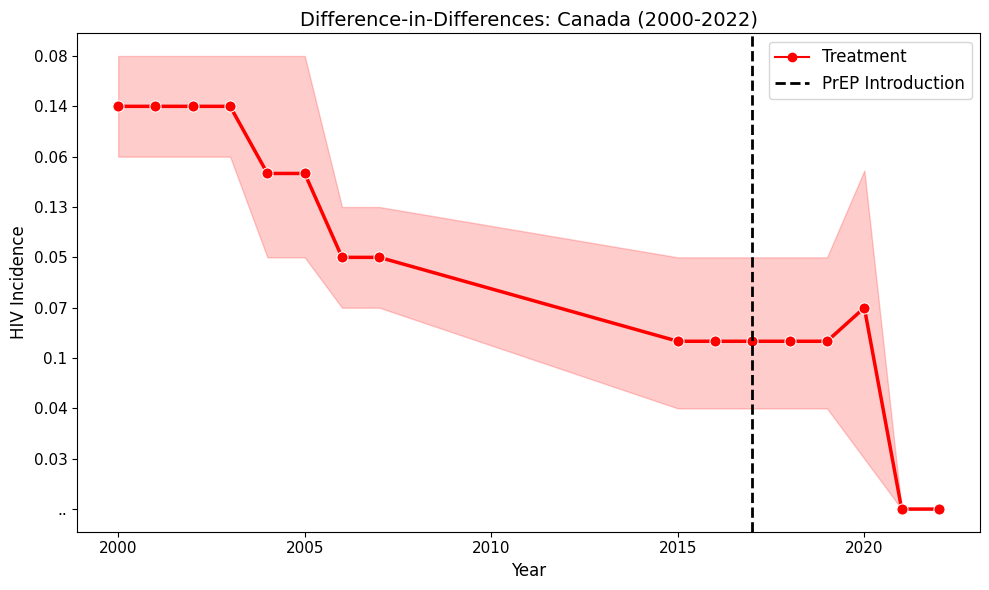

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


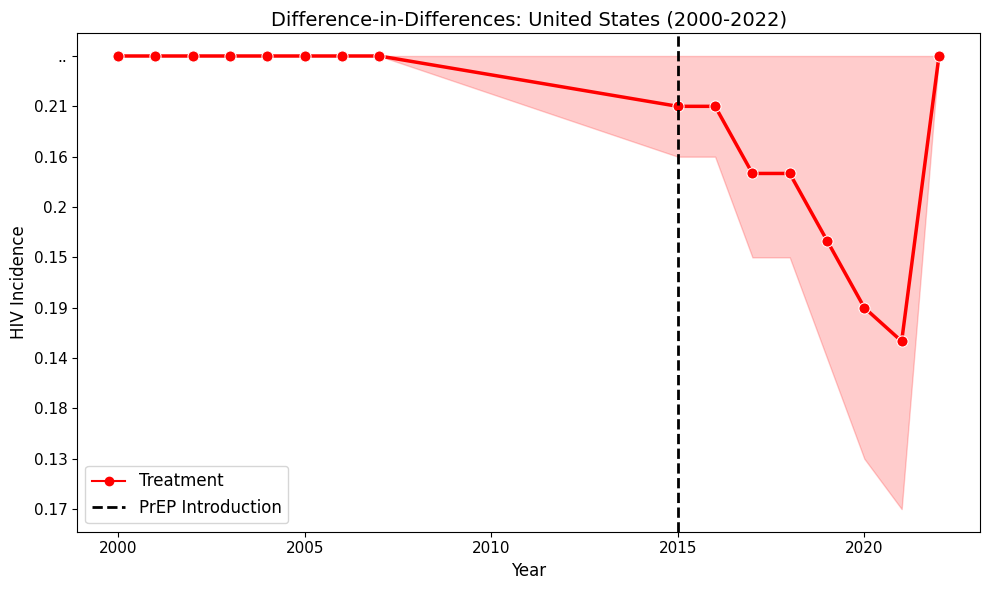

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


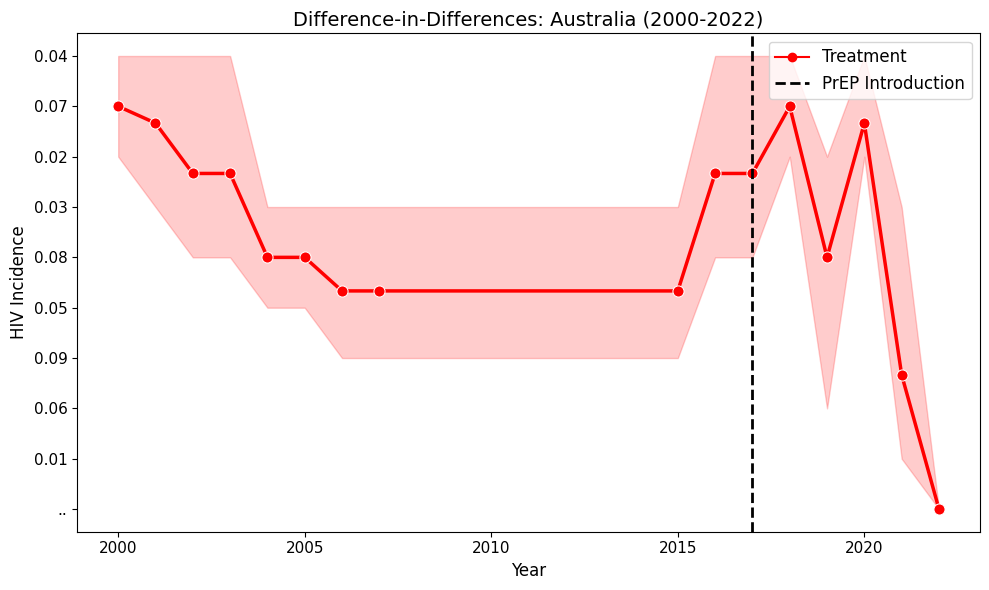

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


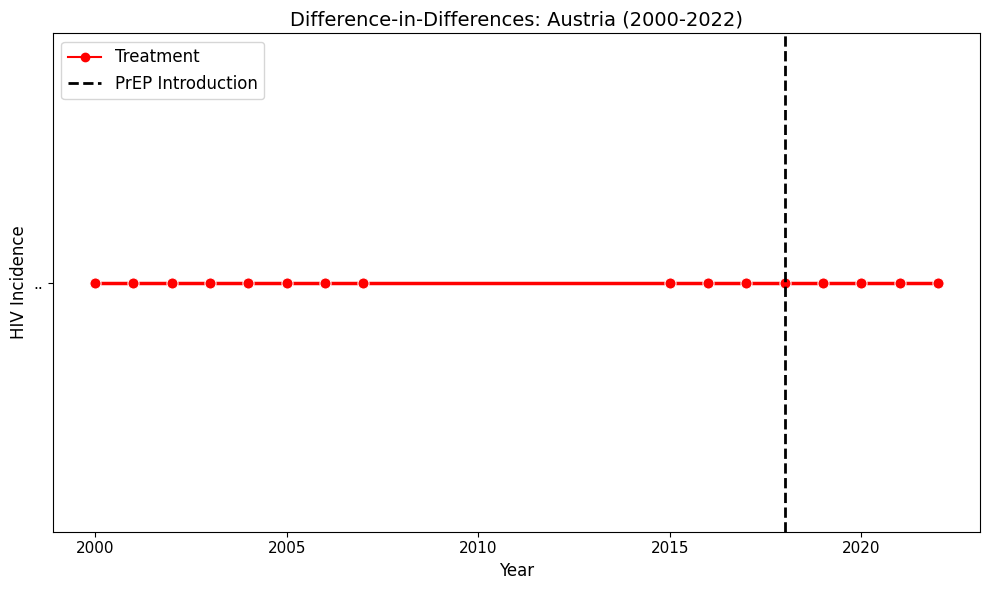

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


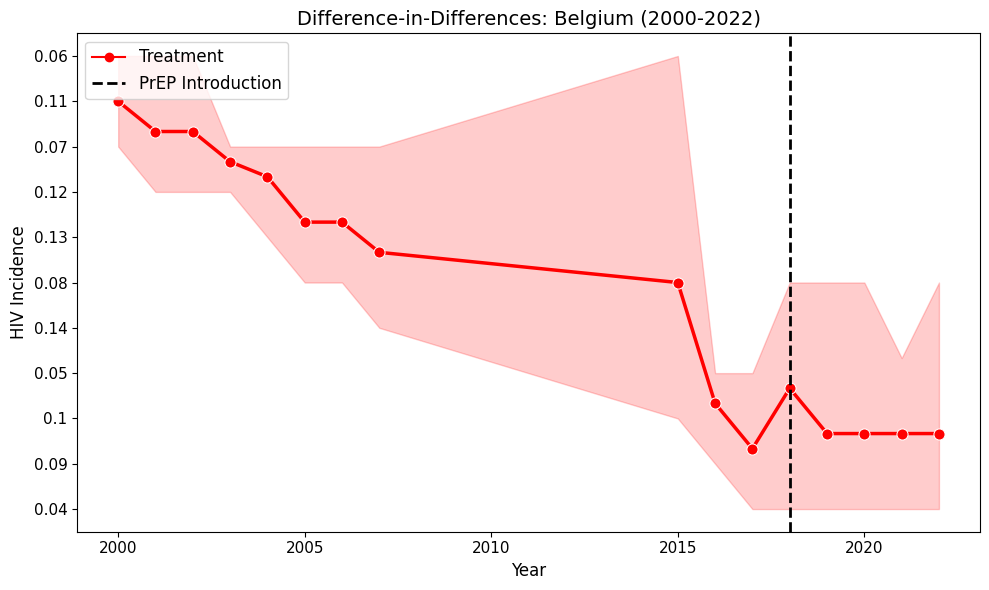

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


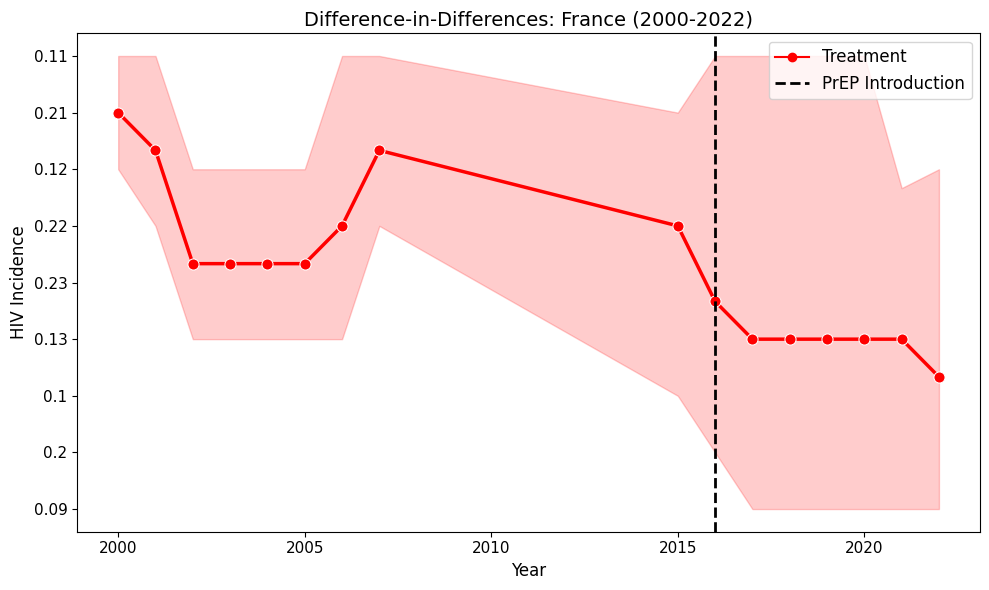

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


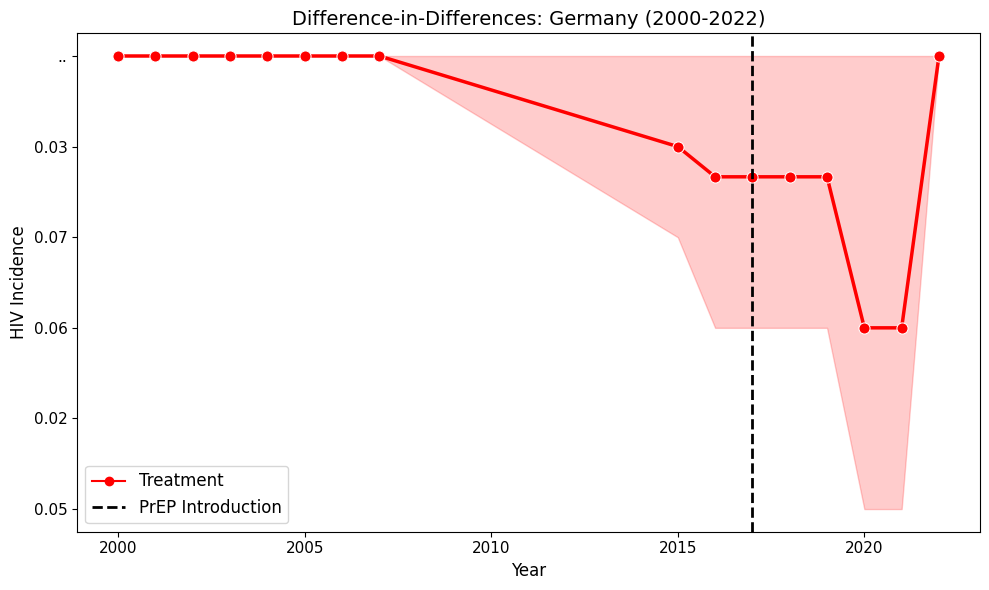

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


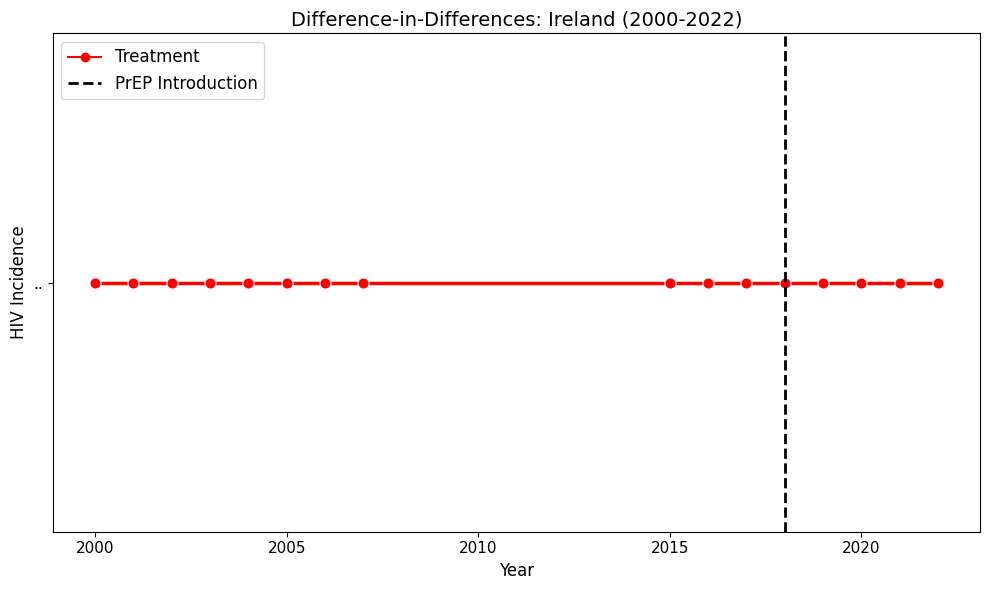

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


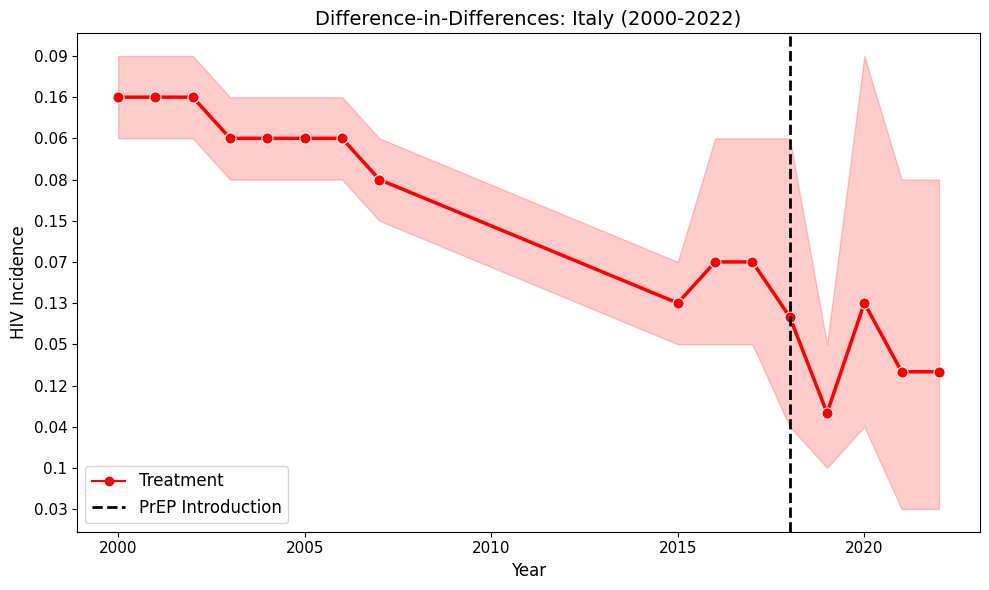

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


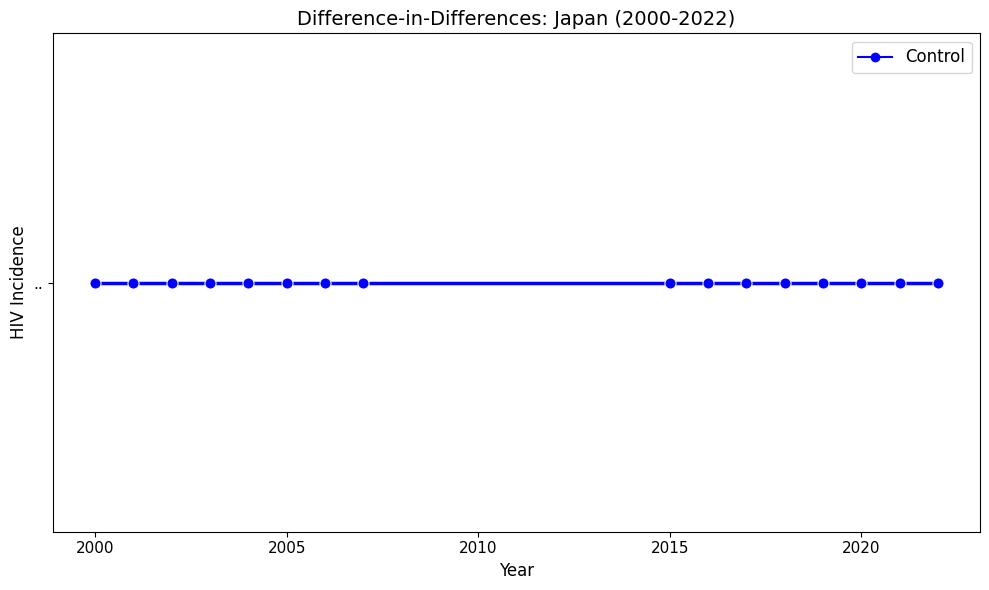

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


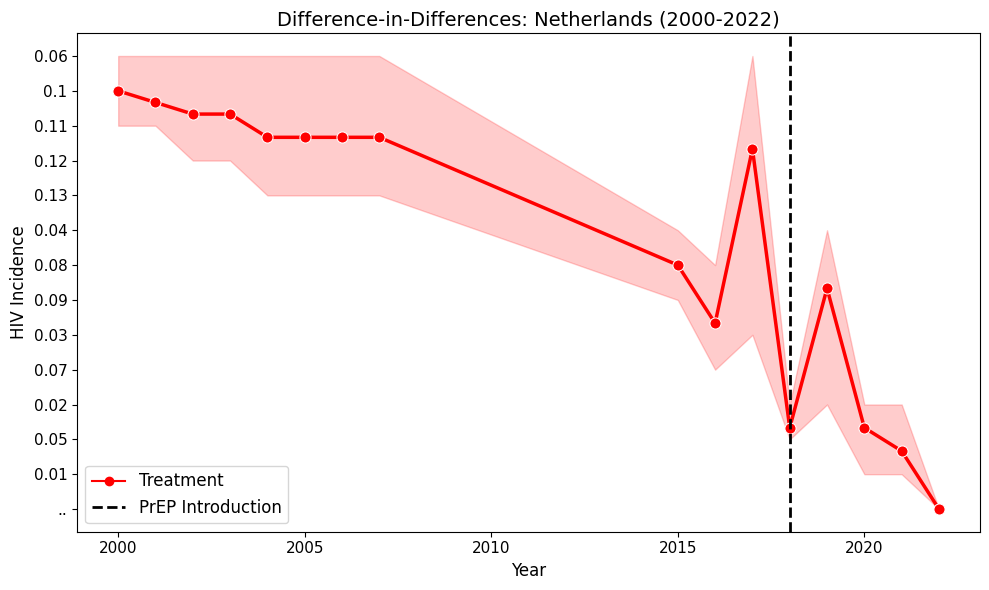

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


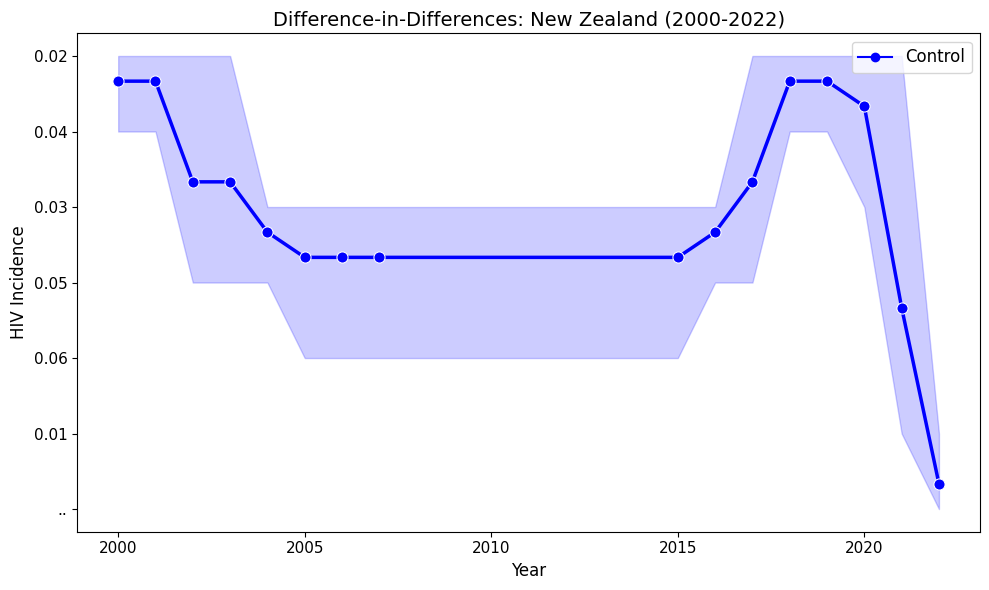

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


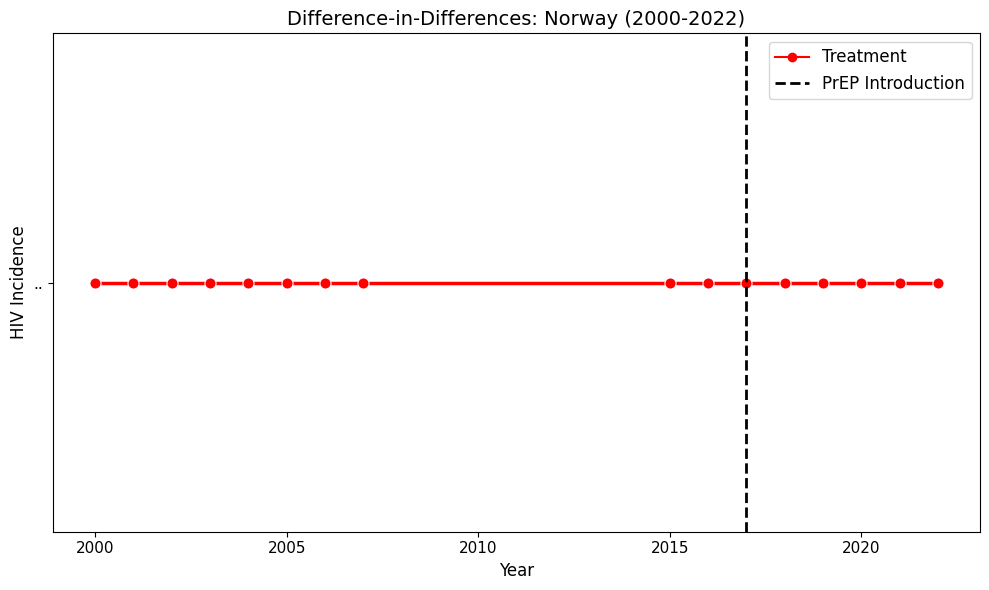

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


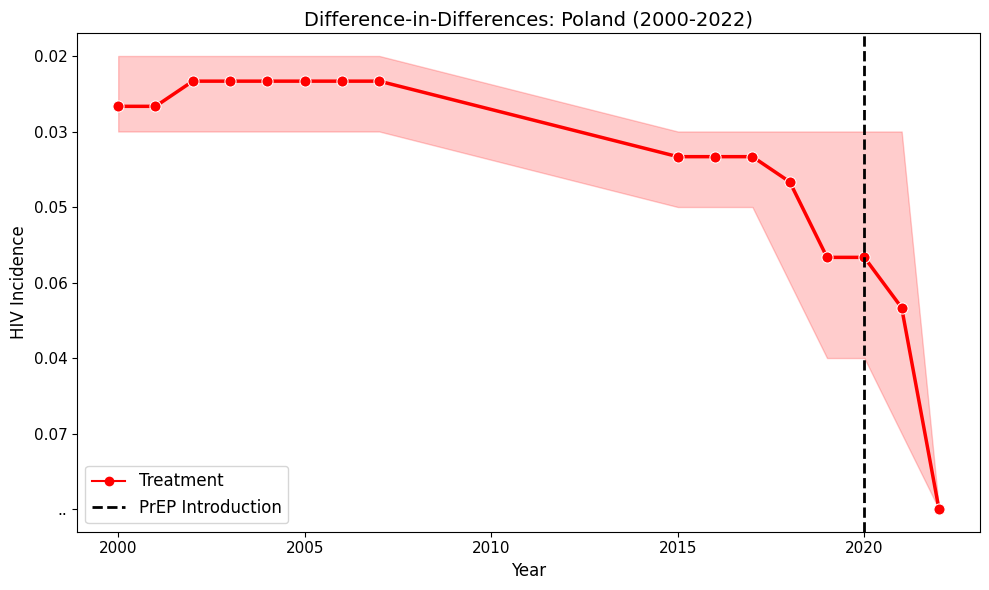

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


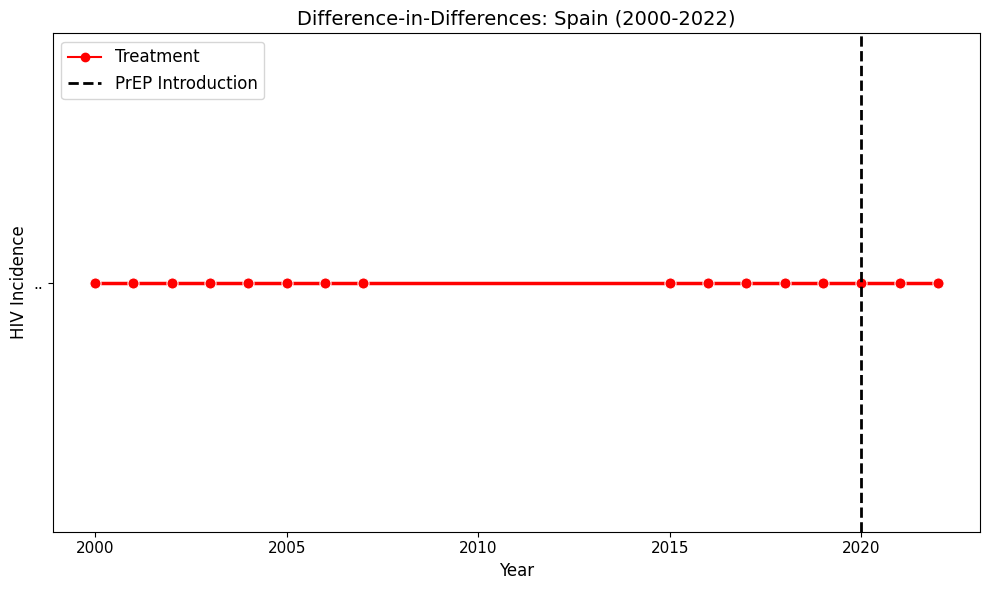

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


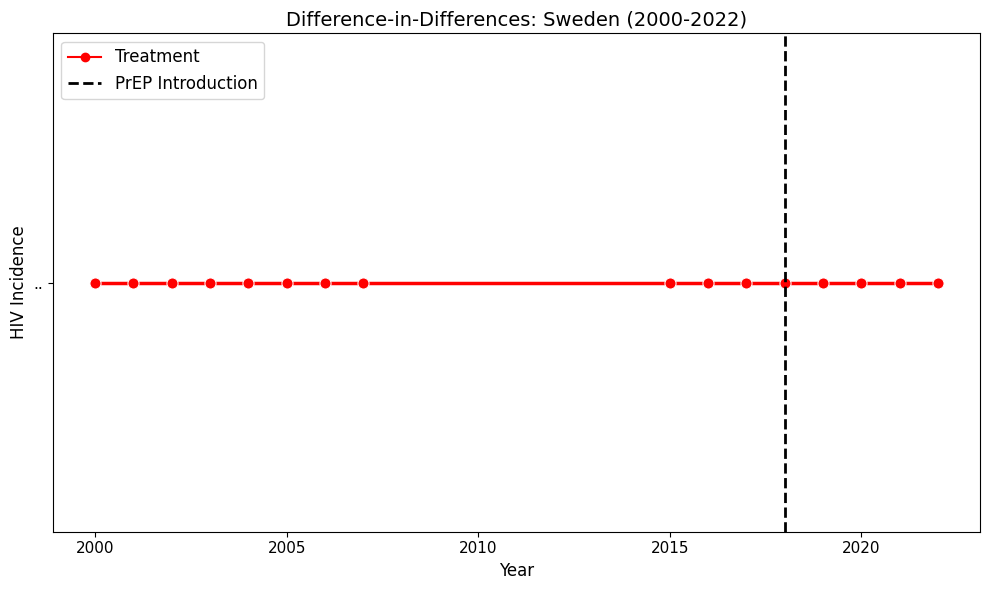

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


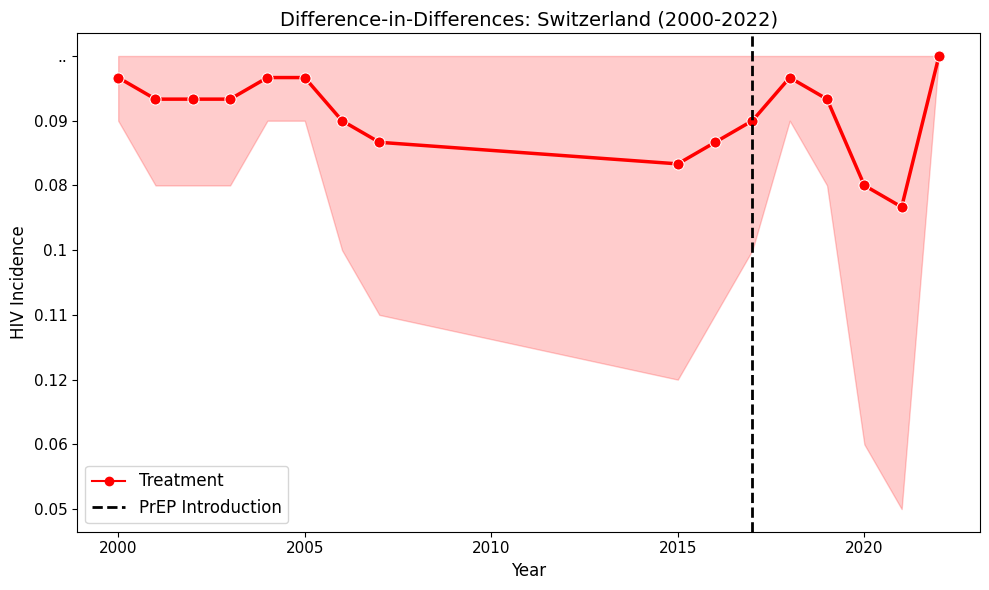

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


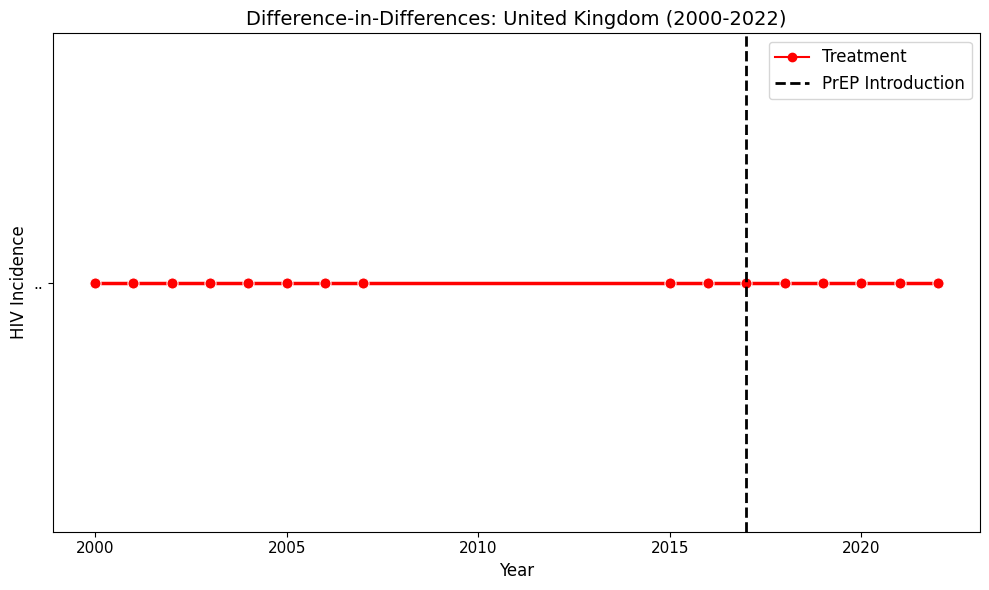

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


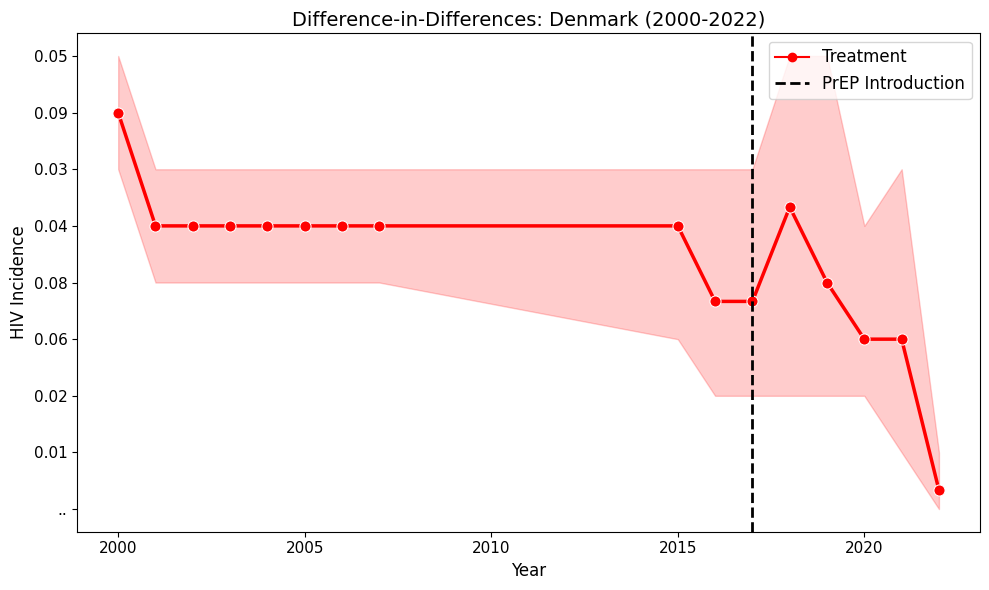

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


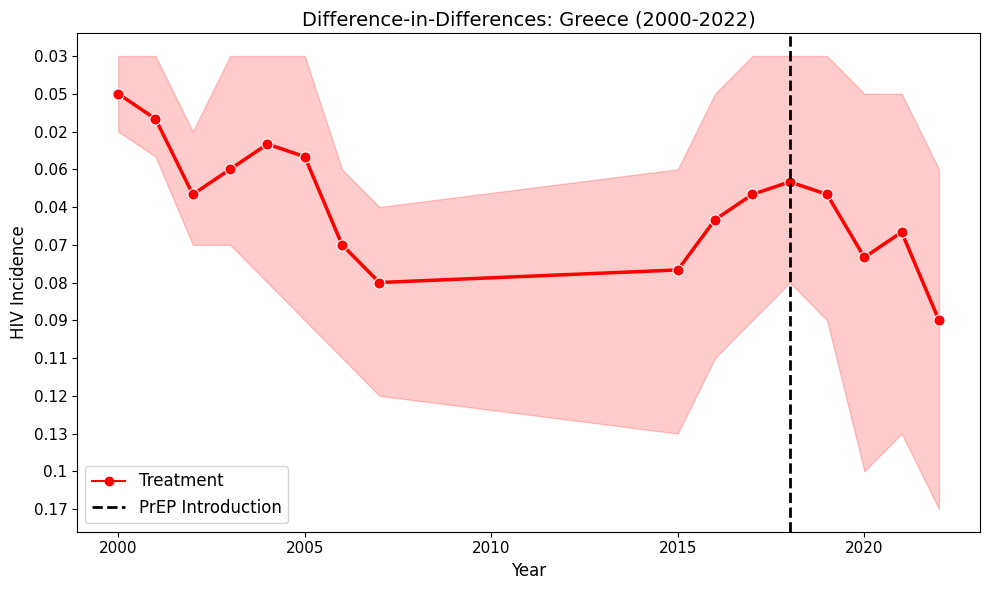

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


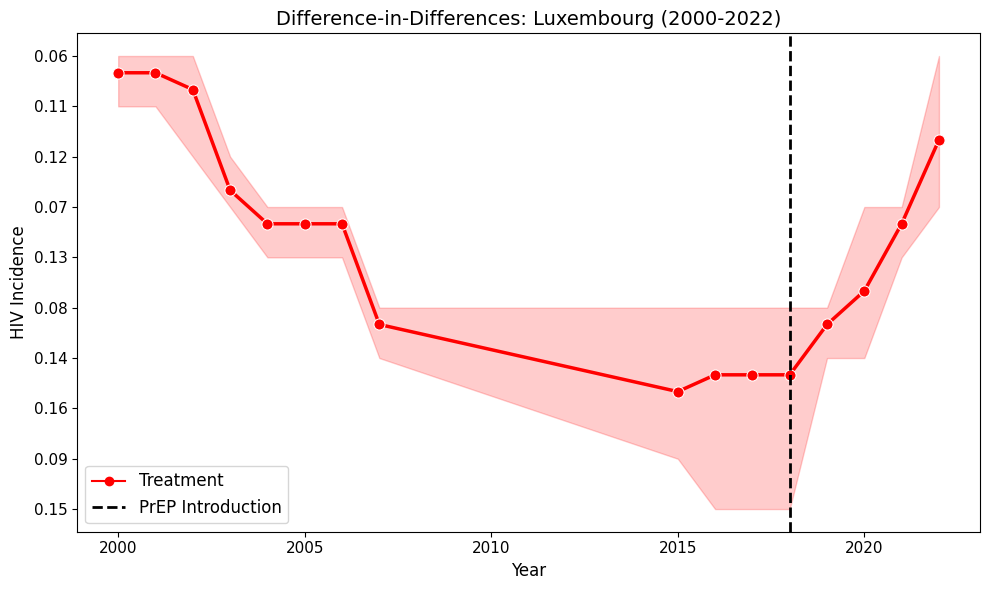

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


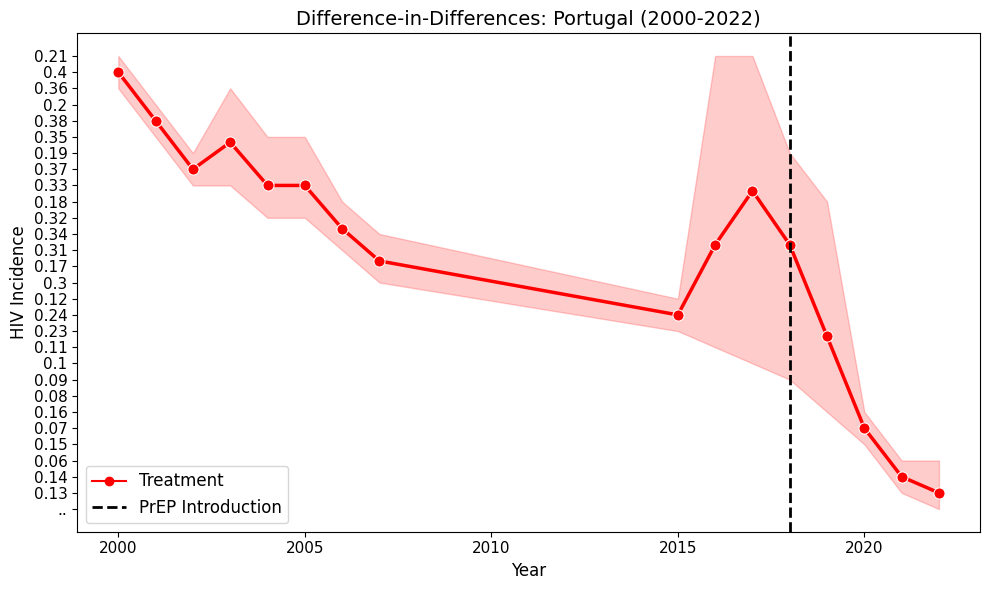

<ipython-input-15-e58eb262ec53>:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


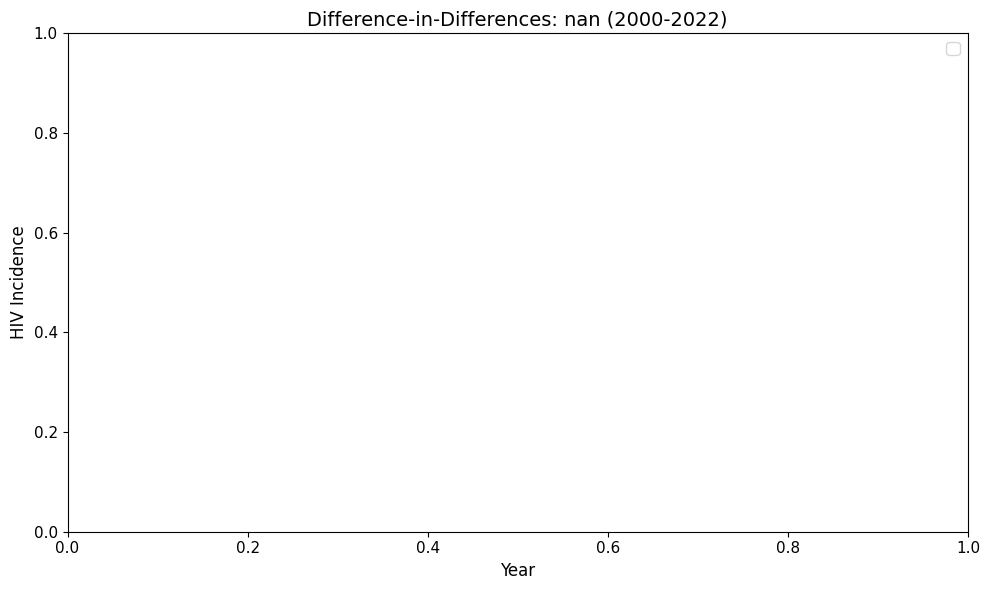

<ipython-input-15-e58eb262ec53>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KeyError: 'y'

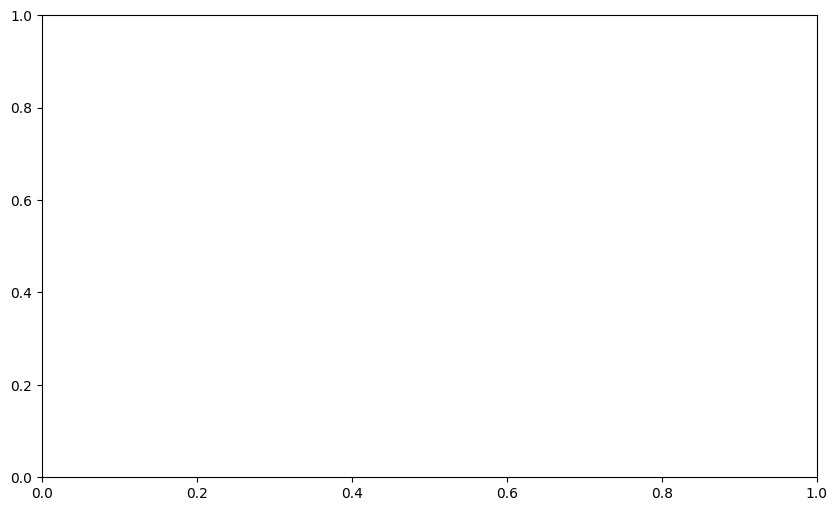

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for the years 2000-2022
filtered_data = data_long[(data_long['Year'] >= 2000) & (data_long['Year'] <= 2022)]

# Get unique country names
countries = filtered_data['Country_Name'].unique()

# Define color palette
palette = {'Control': 'blue', 'Treatment': 'red'}

for country in countries:
    # Filter data for the current country
    country_data = filtered_data[filtered_data['Country_Name'] == country]
    
    plt.figure(figsize=(10, 6))  # Create a new figure for each plot

    # Define Treatment & Control labels
    country_data['Group'] = country_data['Treatment'].map({0: 'Control', 1: 'Treatment'})

    # Line plot
    sns.lineplot(
        data=country_data, x='Year', y='HIV_Incidence', hue='Group', 
        style='Group', markers=True, dashes=False, palette=palette, 
        linewidth=2.5, markersize=8
    )

    # Titles and labels
    plt.title(f"Difference-in-Differences: {country} (2000-2022)", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("HIV Incidence", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    # Add vertical line for PrEP introduction
    min_treated_year = country_data[country_data['Post_PrEP'] == 1]['Year'].min()
    if not pd.isna(min_treated_year):
        plt.axvline(x=min_treated_year, color='black', linestyle="--", lw=2, label="PrEP Introduction")

    # Show legend and plot
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

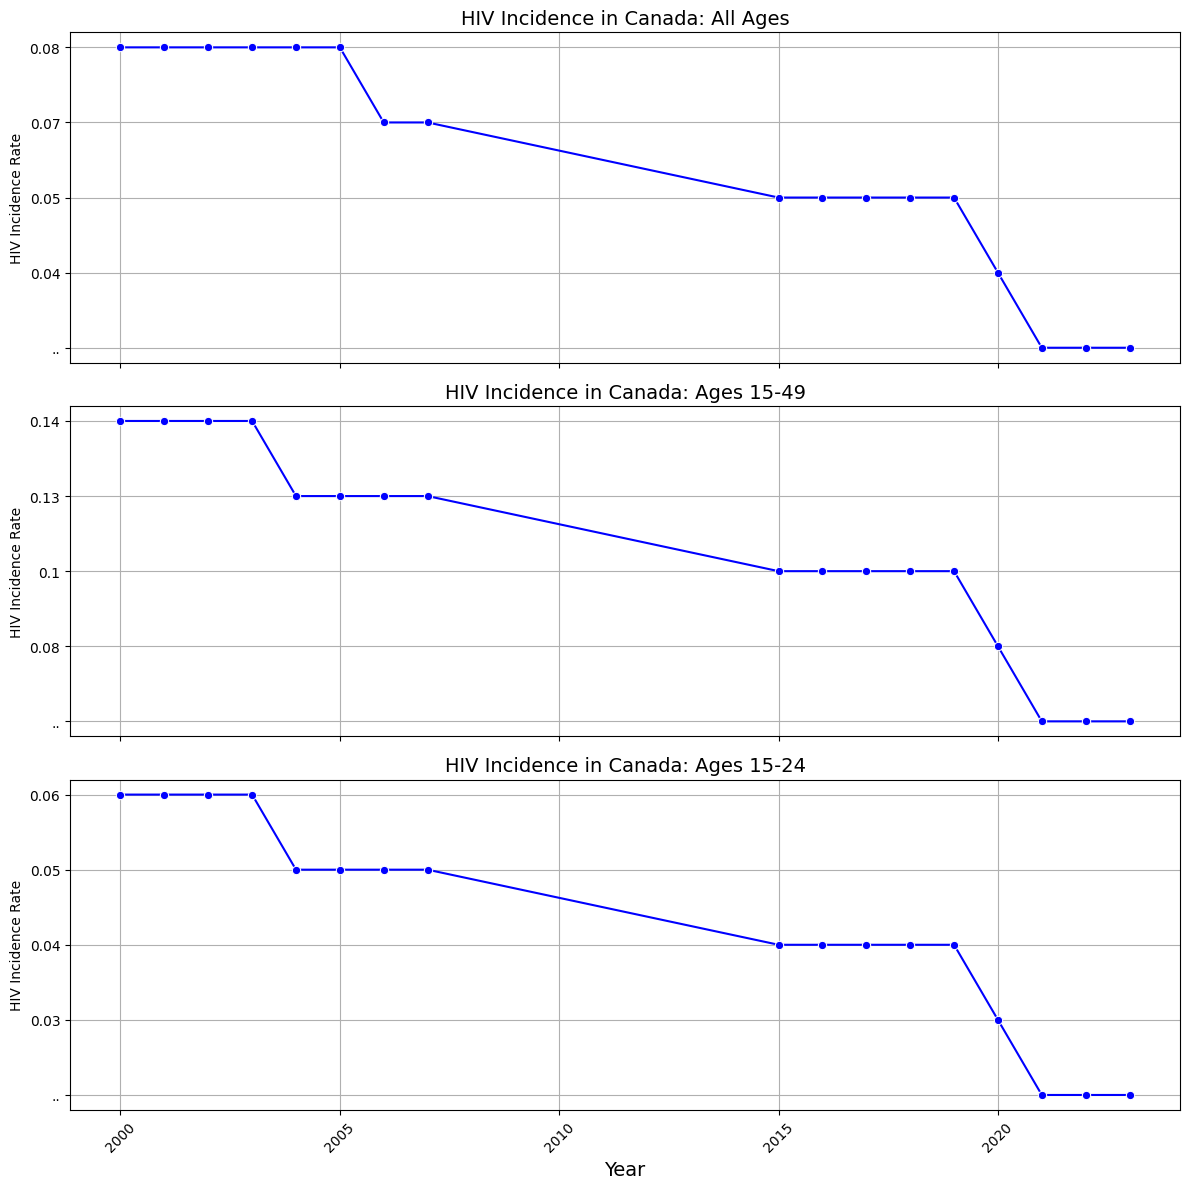

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for Canada only
canada_data = data_long[data_long["Country_Name"] == "Canada"]

# Define age groups
age_groups = {
    "All Ages": "Incidence of HIV, all (per 1,000 uninfected population)",
    "Ages 15-49": "Incidence of HIV, ages 15-49 (per 1,000 uninfected population ages 15-49)",
    "Ages 15-24": "Incidence of HIV, ages 15-24 (per 1,000 uninfected population ages 15-24)"
}

# Set figure size
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot for each age group
for ax, (title, series_name) in zip(axes, age_groups.items()):
    subset = canada_data[canada_data["Series Name"] == series_name]  # Filter for the age group
    sns.lineplot(x="Year", y="HIV_Incidence", data=subset, ax=ax, marker="o", color="b")
    
    ax.set_title(f"HIV Incidence in Canada: {title}", fontsize=14)
    ax.set_ylabel("HIV Incidence Rate")
    ax.grid(True)

# Common X-axis label
plt.xlabel("Year", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("hiv_incidence_in_canada.jpg", format='jpg', dpi=300, bbox_inches='tight')



In [ ]:
plt.savefig("hiv_incidence_trend.jpg", format='jpg', dpi=300, bbox_inches='tight')
